## Homework 4: Neural Networks for Dynamical Systems

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
from scipy import integrate
from scipy.io import loadmat
import matplotlib.pyplot as plt
from matplotlib import rcParams
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable

from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.models import load_model
from keras.layers import Dense
from keras import optimizers
import keras
from tensorflow import set_random_seed


rcParams.update({'font.size': 18})
plt.rcParams['figure.figsize'] = [12, 12]

# %matplotlib notebook

Using TensorFlow backend.


### Download the accompanying ZIP file which includes MATLAB code for solving (i) A reaction-diffusion system of equations, and (ii) The Kuramoto-Sivashinsky (KS) equation.

### 1. Train a NN that can advance the solution from t to t + ∆t for the KS equation


#### Define KS equation

Adapted from MATLAB code kuramoto_sivashinky.m and https://github.com/E-Renshaw/kuramoto-sivashinsky

In [2]:
def KS(boundary):

    # Kuramoto-Sivashinsky equation (from Trefethen)
    # u_t = -u*u_x - u_xx - u_xxxx,  periodic BCs 

    N = 1024
    x = boundary*np.pi*np.arange(1,N+1)/N
    u = np.cos(x/16)*(1+np.sin(x/16))
    v = np.fft.fft(u)

    # Spatial grid and initial condition:
    h    = 0.025
    k    = np.concatenate([np.arange(0,N/2),[0],np.arange(-N/2+1,0)])/16
    L    = k**2 - k**4
    E    = np.exp(h*L)
    E2   = np.exp(h*L/2)
    M    = 16
    r    = np.exp(1j*np.pi*(np.arange(1,M+1)-.5)/M)
    LR   = h*np.tile(L,(M,1)).T + np.tile(r,(N,1))
    Q    = h*np.real(np.mean((np.exp(LR/2)-1)/LR,axis=1))
    f1   = h*np.real(np.mean((-4-LR+np.exp(LR)*(4-3*LR+LR**2))/LR**3,axis=1))
    f2   = h*np.real(np.mean((2+LR+np.exp(LR)*(-2+LR))/LR**3,axis=1))
    f3   = h*np.real(np.mean((-4-3*LR-LR**2+np.exp(LR)*(4-LR))/LR**3,axis=1))

    # Main time-stepping loop:
    uu   = u
    tt   = 0
    tmax = 100
    nmax = round(tmax/h) 
    nplt = np.floor((tmax/250)/h)
    g    = -0.5j * k

    for n in range(1, nmax + 1):
        t  = n*h
        Nv = g*np.fft.fft(np.real(np.fft.ifft(v))**2)
        a  = E2*v+Q*Nv
        Na = g*np.fft.fft(np.real(np.fft.ifft(a))**2)
        b  = E2*v+Q*Na
        Nb = g*np.fft.fft(np.real(np.fft.ifft(b))**2)
        c  = E2*a+Q*(2*Nb-Nv);
        Nc = g*np.fft.fft(np.real(np.fft.ifft(c))**2)
        v  = E*v+Nv*f1+2*(Na+Nb)*f2+Nc*f3 

        if n%nplt == 0:
            u  = np.real(np.fft.ifft(v))
            uu = np.vstack([uu, u]) 
            tt = np.append(tt, t)
            
    return uu

In [3]:
uu32 = KS(32)

Text(0.5, 1.0, 'Kuramoto-Sivashinsky equation')

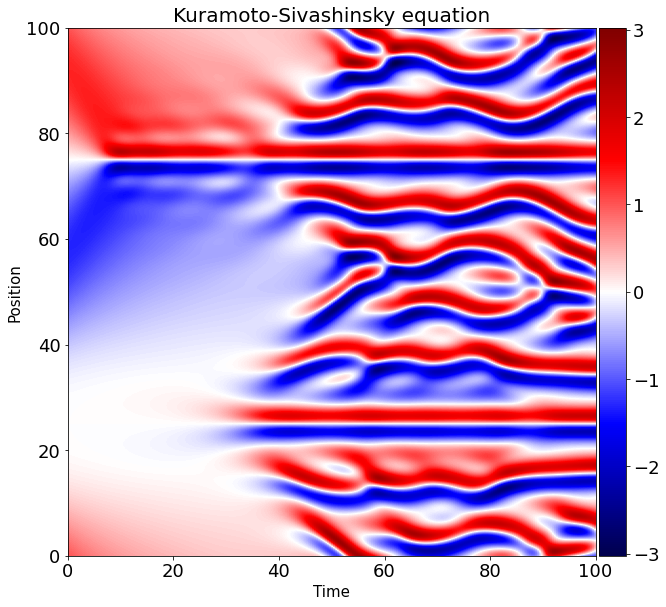

In [4]:
fig, ax = plt.subplots(figsize=(10,10))
h = ax.imshow(uu32.T,extent=[0, 100, 0, 100],cmap='seismic')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(h, cax=cax)
ax.set_xlabel('Time', fontsize = 15)
ax.set_ylabel('Position', fontsize = 15)
ax.set_title('Kuramoto-Sivashinsky equation', fontsize = 20)

#### Split into train and test data

In [5]:
X      = uu32[:-1, :]
Xprime = uu32[1:, :]

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, Xprime, test_size=0.25)

#### Define Neural Network

In [7]:
# model = Sequential()

# model.add(Dense(100, activation='relu'))
# model.add(Dense(100, activation='relu'))
# model.add(Dense(100, activation='relu'))
# model.add(Dense(1024))

# model.compile(optimizer=optimizers.Adam(learning_rate=0.01), loss='mse', validation_split=0.2)

In [8]:
# %%capture
# model.fit(X_train, y_train, epochs=100)
# model.summary()

In [9]:
# model.save('models/KS_model.h5')
model = load_model('models/KS_model.h5')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [10]:
def predict_KS(uu_l):
    u0 = uu_l[:-1, :][0]
    pred = u0.reshape(1, 1024)

    for i in range(100-1):
        u0 = model.predict(u0.reshape((1, 1024)))
        pred = np.vstack([pred, u0]) 
    return pred

In [11]:
uu32_pred = predict_KS(uu32)

Text(0.5, 1.0, 'Kuramoto-Sivashinsky equation')

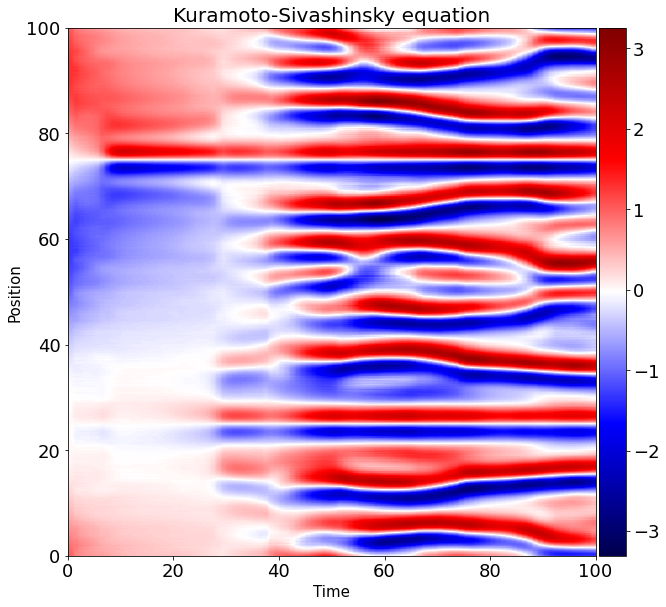

In [12]:
fig, ax = plt.subplots(figsize=(10,10))
h = ax.imshow(uu32_pred.T,extent=[0, 100, 0, 100],cmap='seismic')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(h, cax=cax)
ax.set_xlabel('Time', fontsize = 15)
ax.set_ylabel('Position', fontsize = 15)
ax.set_title('Kuramoto-Sivashinsky equation', fontsize = 20)

### 2. Compare your evolution trajectories for your NN against using the ODE time-stepper provided with different initial conditions

In [13]:
uu10 = KS(10)
uu100 = KS(100)
uu1000 = KS(1000)
uu3000 = KS(3000)

In [14]:
uu10_pred   = predict_KS(uu10)
uu100_pred  = predict_KS(uu100)
uu1000_pred = predict_KS(uu1000)
uu3000_pred = predict_KS(uu3000)

In [15]:
inputs = [uu10,uu10_pred, uu32,uu32_pred, uu100,uu100_pred, uu1000,uu1000_pred, uu3000,uu3000_pred]
ls = ['boundary = 10', 'prediction', 
      'boundary = 32', 'prediction', 
      'boundary = 100','prediction', 
      'boundary = 1000','prediction', 
      'boundary = 3000', 'prediction']

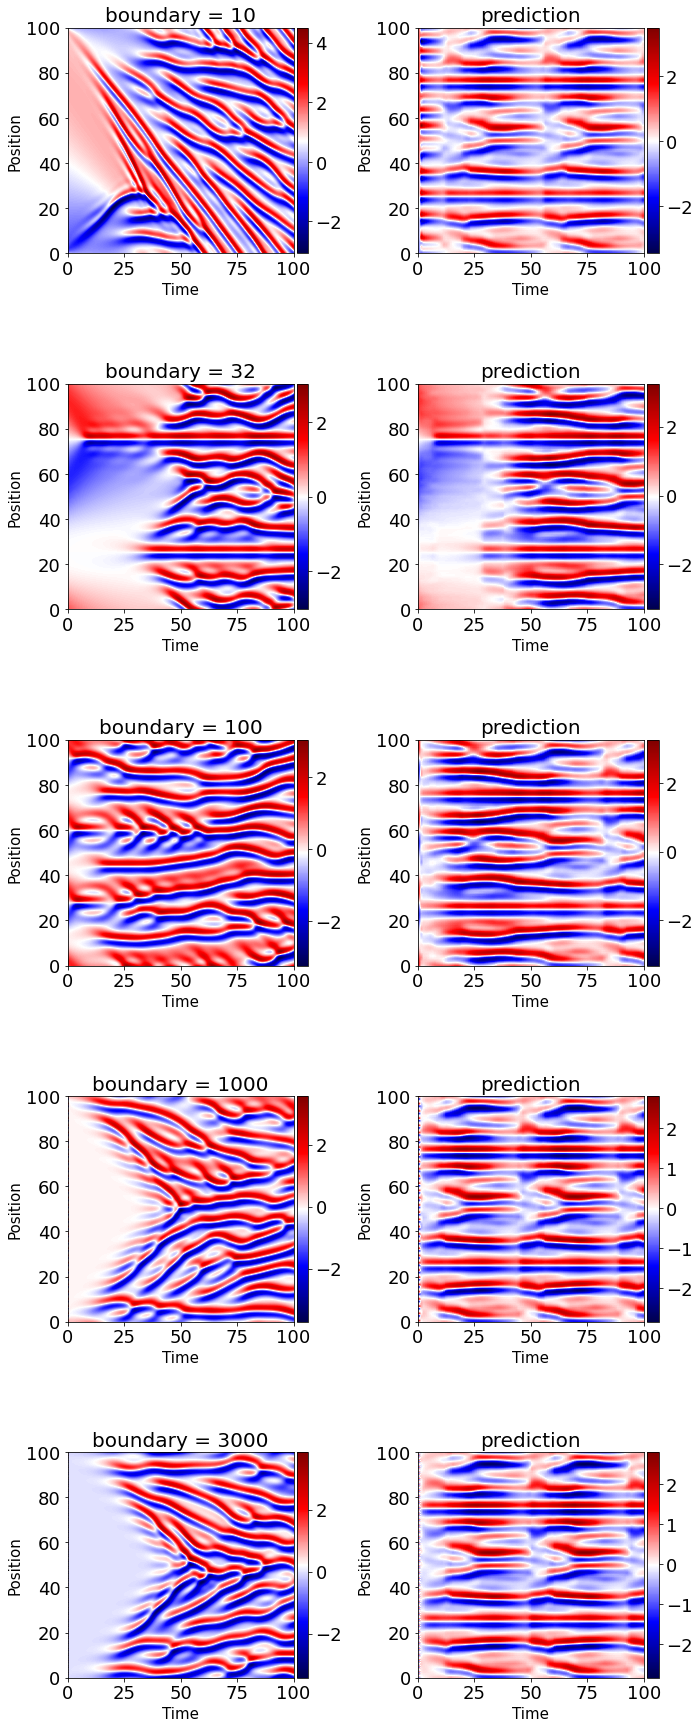

In [16]:
figsize=(10,25)
plt.figure(figsize=figsize)

rows = 5
columns = 2

for i in range(rows*columns):
    ax = plt.subplot(rows, columns, i + 1)
    h = ax.imshow(inputs[i].T,extent=[0, 100, 0, 100],cmap='seismic')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(h, cax=cax)
    ax.set_xlabel('Time', fontsize = 15)
    ax.set_ylabel('Position', fontsize = 15)
    ax.set_title(ls[i], fontsize = 20)
    
plt.tight_layout()

### 3. For the reaction-diffusion system, first project to a low-dimensional subspace via the SVD and see how forecasting works in the low-rank variables.

#### Load reaction-diffusion data

In [17]:
data = loadmat('data/reaction_diffusion_big.mat')

In [18]:
t = data['t']
u = data['u']
v = data['v']
x = data['x']
y = data['y']

#### SVD

In [19]:
X = u.reshape(v.shape[0]*v.shape[1], v.shape[2])

In [20]:
U, S, Vh = np.linalg.svd(X, full_matrices=False)
V = Vh.conj().T

In [21]:
var_explained = np.round(S**2/np.sum(S**2), decimals=100)
thresh = 0.999999
cdf=np.cumsum(var_explained)
n_components = np.where(cdf>thresh)[0][0]
n_components

9

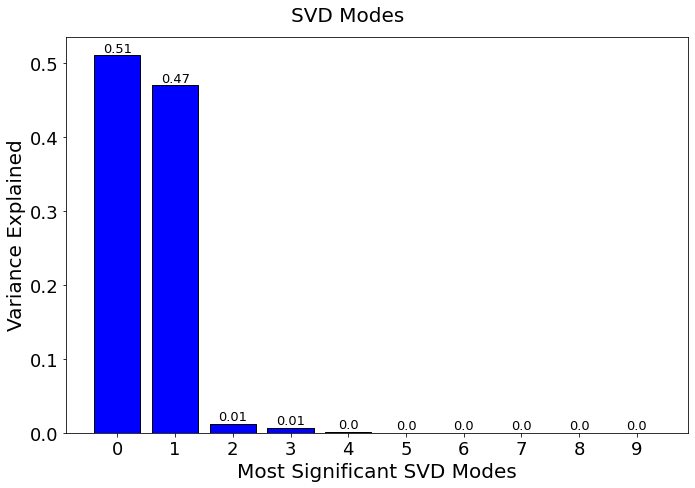

In [22]:
fig, ax = plt.subplots(figsize=(10,7))
bar_plot = ax.bar(np.arange(len(var_explained[:n_components+1])), 
                  var_explained[:n_components+1], 
                  color="blue", 
                  ec='k')

for p in bar_plot.patches:
    width = p.get_width()
    ax.text(p.get_x() + p.get_width()/2., 
            p.get_height()+0.001, 
            np.round(p.get_height(), 2), 
            fontsize=13, color='k', ha='center', va='bottom')
    
    
ax.set_xlabel('Most Significant SVD Modes', fontsize=20)
ax.set_ylabel('Variance Explained', fontsize=20)

fig.suptitle('SVD Modes', fontsize=20)
plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.xticks(np.arange(0, 10, step=1));

In [23]:
r = n_components
Ur = U[:, :r]
Vr = V[:, :r]
Sr = S[:r]

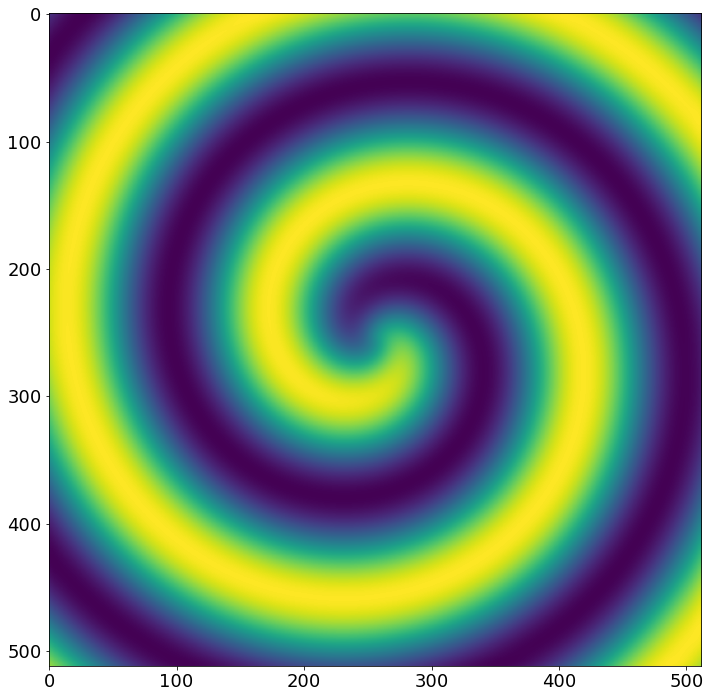

In [24]:
X_reconstructed = Ur @ (Ur.T @ X)
X_reconstructed = X_reconstructed.reshape(v.shape[0], v.shape[1], v.shape[2])

plt.imshow(X_reconstructed[:,:,0])

#### Compare to ODE and NN on SVD forecast

In [25]:
Xr = Ur.T @ X

In [26]:
Xt = Xr[:,:-1]
yt = Xr[:,1:]

In [27]:
X_train = Xt[:,:-40]
X_test  = Xt[:,-40:]
y_train = yt[:,:-40]
y_test  = yt[:,-40:]

In [28]:
# model = Sequential()

# model.add(Dense(100, activation='relu'))
# model.add(Dense(100, activation='relu'))
# model.add(Dense(100, activation='relu'))
# model.add(Dense(X_train.shape[0]))

# model.compile(optimizer=optimizers.Adam(learning_rate=0.01), loss='mse', validation_split=0.2)

In [29]:
# %%capture
# model.fit(X_train.T, y_train.T, epochs=1000)
# model.summary()

In [30]:
# model.save('models/RD_model.h5')
model = load_model('models/RD_model.h5')

In [31]:
X0 = Xr.T[0]
pred = X0.reshape(1, 9)

for i in range(200):
    X0 = model.predict(X0.reshape((1, 9)))
    pred = np.vstack([pred, X0]) 

In [32]:
pp = Ur @ pred.T
pp = pp.reshape(v.shape[0], v.shape[1], v.shape[2])

In [33]:
# import matplotlib.animation as animation
# from IPython.display import HTML

# fig = plt.figure()
# ims = []
# for i in u.T:
#     im = plt.imshow(i, animated=True)
#     ims.append([im])
# ani = animation.ArtistAnimation(fig, ims)
# plt.close(ani._fig)
# HTML(ani.to_html5_video())

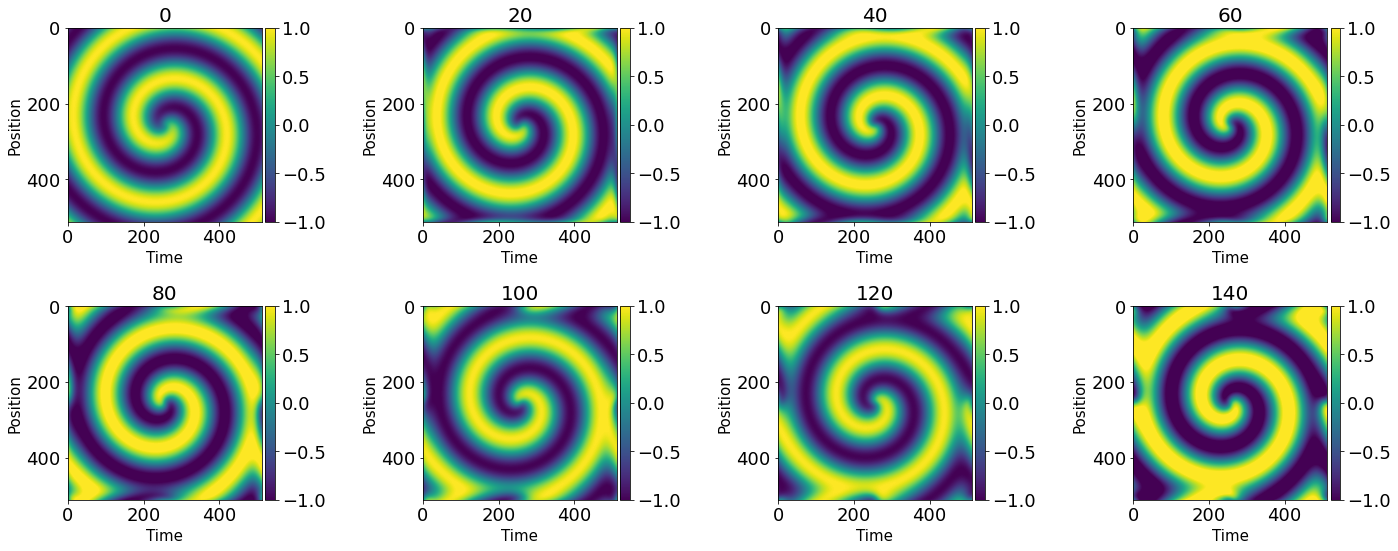

In [34]:
figsize=(20,8)
plt.figure(figsize=figsize)

rows = 2
columns = 4

c = 0

for i in range(rows*columns):
    
    ax = plt.subplot(rows, columns, i + 1)
    h = ax.imshow(pp[:,:,c], vmin=-1, vmax=1)
    
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(h, cax=cax)
    ax.set_xlabel('Time', fontsize = 15)
    ax.set_ylabel('Position', fontsize = 15)
    ax.set_title(str(c), fontsize = 20)

    c = c+20
    
plt.tight_layout()

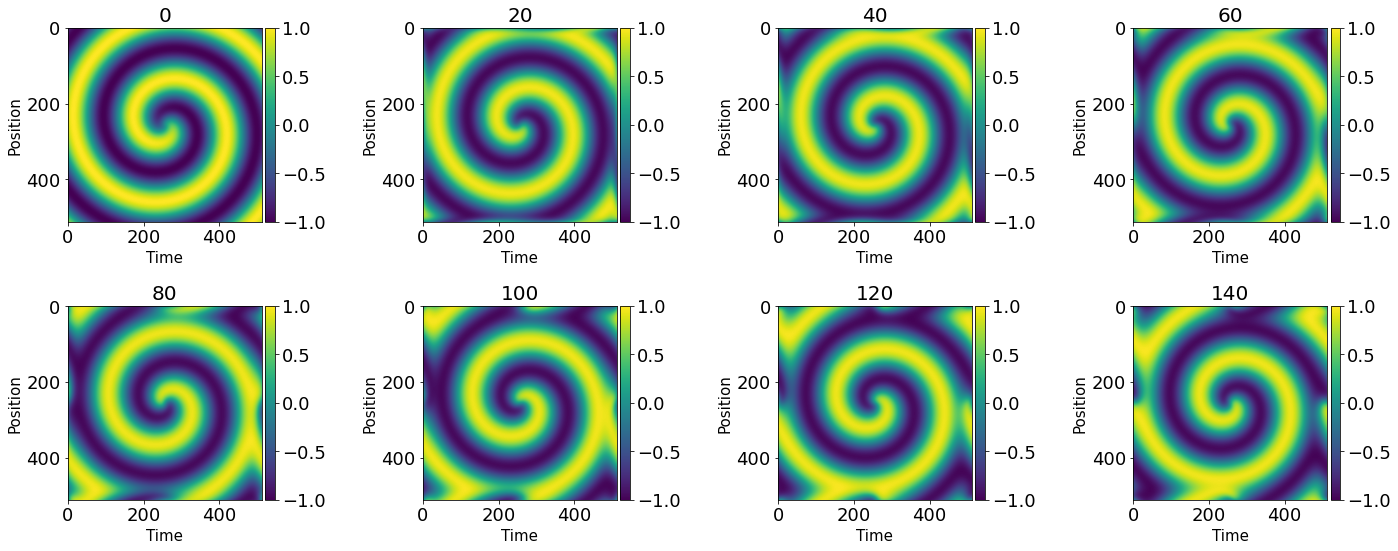

In [35]:
figsize=(20,8)
plt.figure(figsize=figsize)

rows = 2
columns = 4

c = 0

for i in range(rows*columns):
    
    ax = plt.subplot(rows, columns, i + 1)
    h = ax.imshow(u[:,:,c], vmin=-1, vmax=1)
    
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(h, cax=cax)
    ax.set_xlabel('Time', fontsize = 15)
    ax.set_ylabel('Position', fontsize = 15)
    ax.set_title(str(c), fontsize = 20)

    c = c+20
    
plt.tight_layout()

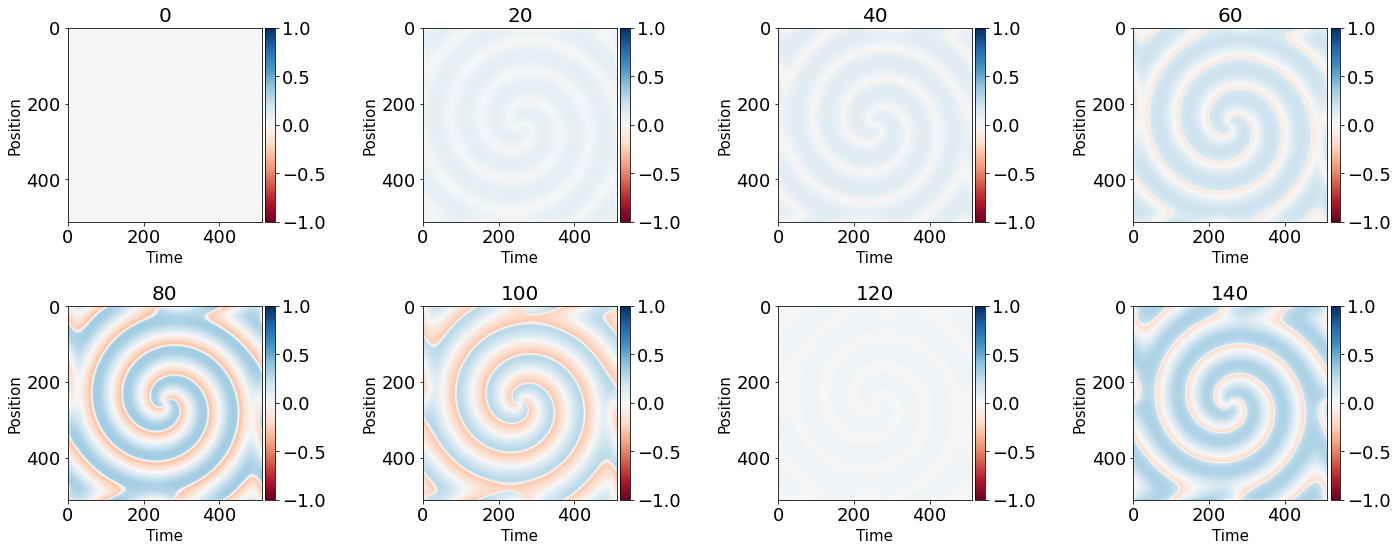

In [36]:
s = abs(pp) - abs(u)

figsize=(20,8)
plt.figure(figsize=figsize)

rows = 2
columns = 4

c = 0

for i in range(rows*columns):
    
    ax = plt.subplot(rows, columns, i + 1)
    h = ax.imshow(s[:,:,c],cmap='RdBu', vmin=-1, vmax=1)
    
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(h, cax=cax)
    ax.set_xlabel('Time', fontsize = 15)
    ax.set_ylabel('Position', fontsize = 15)
    ax.set_title(str(c), fontsize = 20)

    c = c+20
    
plt.tight_layout()

### For the Lorenz equations (code given out previously in class emails), consider the following.
### 1. Train a NN to advance the solution from t to t+∆t for ρ=10, 28 and 40. Now see how well your NN works for future state prediction for ρ = 17 and ρ = 35.

In [37]:
def lorenz_deriv(x_y_z, t0, sigma, beta, rho):
    x, y, z = x_y_z
    return [sigma * (y - x), x * (rho - z) - y, x * y - beta * z]

In [38]:
dt = 0.01
T = 8
t = np.arange(0,T+dt,dt)
beta = 8/3
sigma = 10
x0 = (0,1,20)

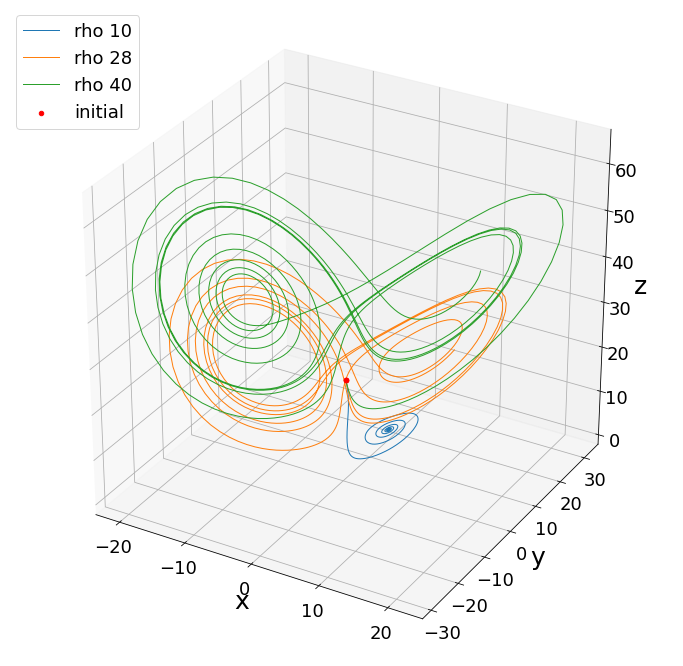

In [39]:
fig,ax = plt.subplots(1,1,subplot_kw={'projection': '3d'})

data = []

for i in [10,28,40]:
    x_t = integrate.odeint(lorenz_deriv, 
                           x0, 
                           t,
                           args=(sigma,beta,i),
                           rtol=10**(-12), 
                           atol=10**(-12)*np.ones_like(x0))
    x, y, z = x_t.T
    ax.plot(x, y, z,linewidth=1)
    ax.scatter(x[0],y[0],z[0],color='r')
    
    r = x_t.shape[0]
    d = np.hstack((x_t, (i*np.ones(r)).reshape((r,1))))
    
    data.append(d)

ax.set_xlabel('x', fontsize = 25)
ax.set_ylabel('y', fontsize = 25)
ax.set_zlabel('z', fontsize = 25)

ax.legend(['rho 10','rho 28','rho 40', 'initial'], loc='upper left')
plt.show()

In [40]:
data = np.vstack(data)

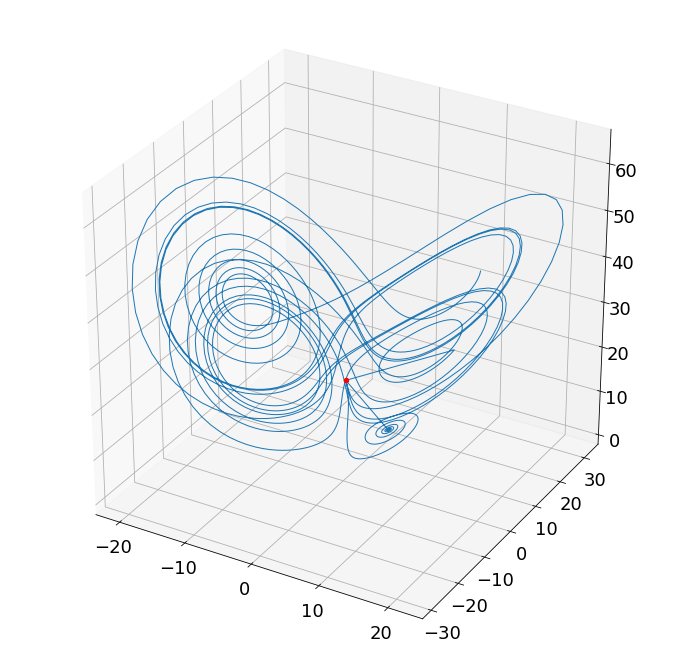

In [41]:
fig,ax = plt.subplots(1,1,subplot_kw={'projection': '3d'})
x, y, z = data[:,:-1].T
ax.plot(x, y, z,linewidth=1)
ax.scatter(x[0],y[0],z[0],color='r')

In [42]:
X = data.T[:,:-1]
Xprime = data.T[:,1:]

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X.T, Xprime.T, test_size=0.25)

In [44]:
model = Sequential()

model.add(Dense(100, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(X_train.shape[1]))

model.compile(optimizer=optimizers.Adam(learning_rate=0.001), loss='mse', validation_split=0.2)

In [45]:
%%capture
model.fit(X_train, y_train, epochs=200, batch_size=1000)
model.summary()

In [46]:
# model.save('models/LZ_model.h5')
model = load_model('models/LZ_model.h5')

In [47]:
X0 = X.T[0]
pred = X0.reshape(1, 4)

for i in range(len(t)):
    X0 = model.predict(X0.reshape((1, 4)))
    pred = np.vstack([pred, X0]) 

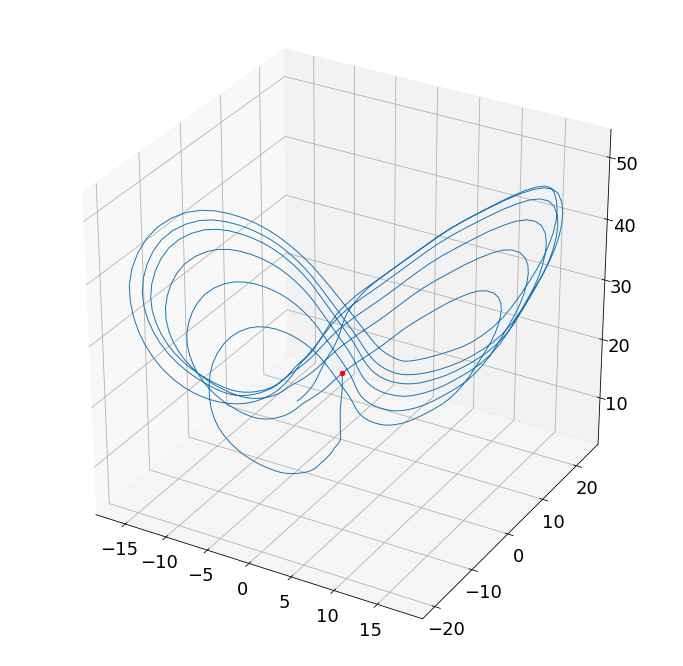

In [48]:
fig,ax = plt.subplots(1,1,subplot_kw={'projection': '3d'})
x, y, z = pred[:,:-1].T
ax.plot(x, y, z,linewidth=1)
ax.scatter(x[0],y[0],z[0],color='r')

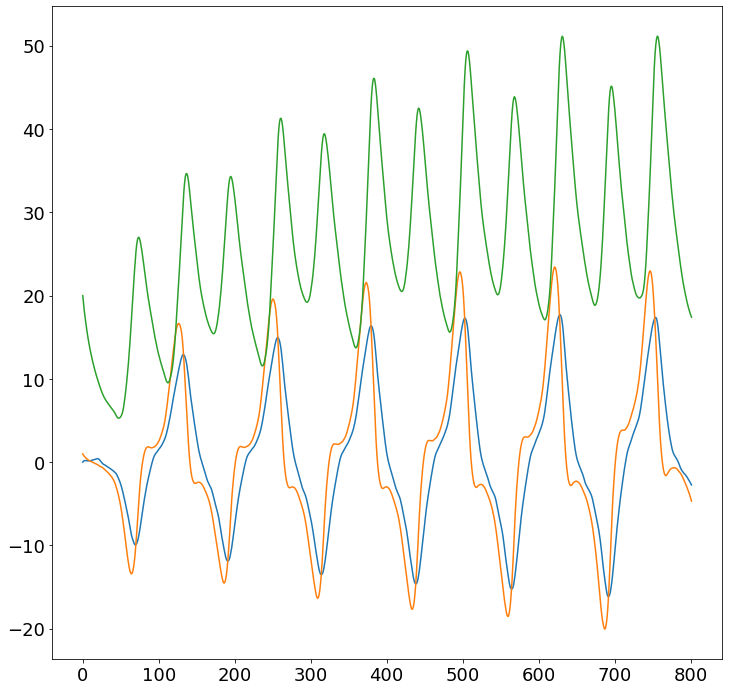

In [49]:
plt.plot(x)
plt.plot(y)
plt.plot(z)

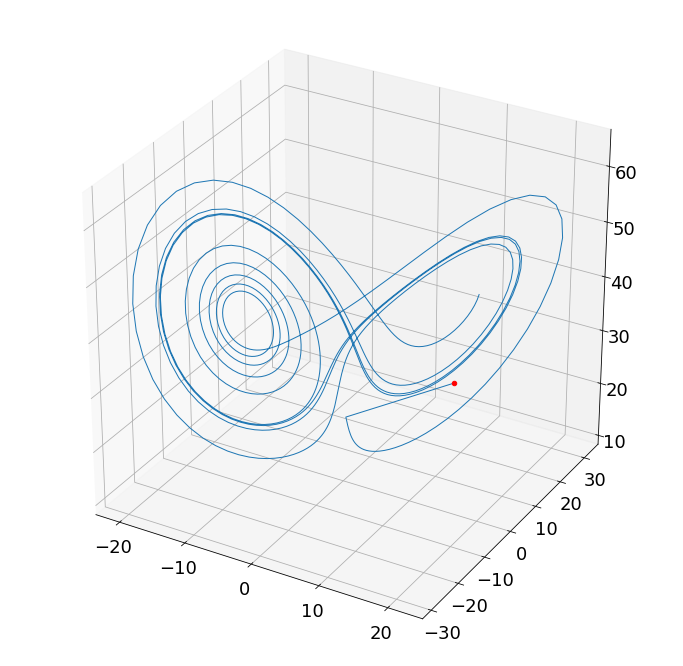

In [50]:
fig,ax = plt.subplots(1,1,subplot_kw={'projection': '3d'})
x, y, z = X[:-1,-801:]
ax.plot(x, y, z,linewidth=1)
ax.scatter(x[0],y[0],z[0],color='r')

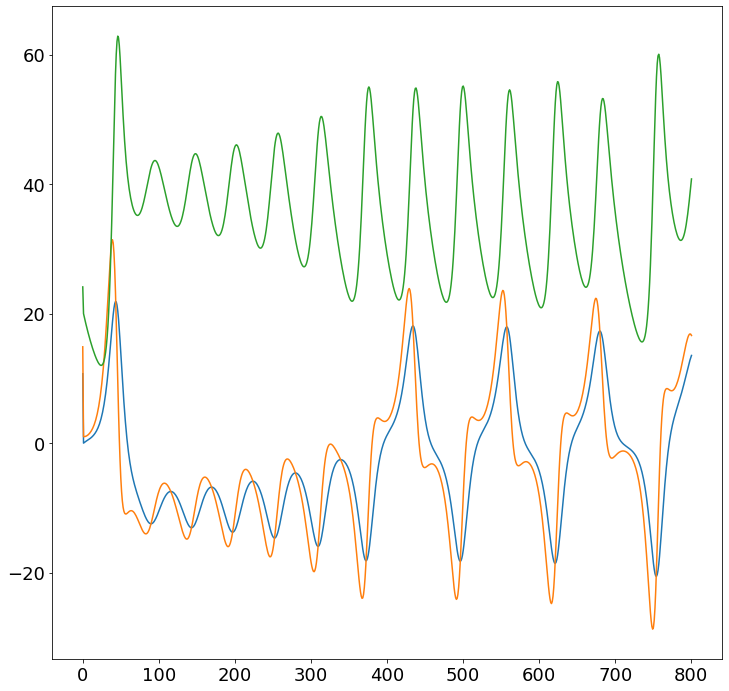

In [51]:
plt.plot(x)
plt.plot(y)
plt.plot(z)

In [52]:
rho = 17

x_t = integrate.odeint(lorenz_deriv, 
                       x0, 
                       t,
                       args=(sigma,beta,rho),
                       rtol=10**(-12), 
                       atol=10**(-12)*np.ones_like(x0))
x, y, z = x_t.T

r = x_t.shape[0]
d = np.hstack((x_t, (rho*np.ones(r)).reshape((r,1))))

In [53]:
X0 = d[0]
pred = X0.reshape(1, 4)

for i in range(len(t)):
    X0 = model.predict(X0.reshape((1, 4)))
    pred = np.vstack([pred, X0]) 

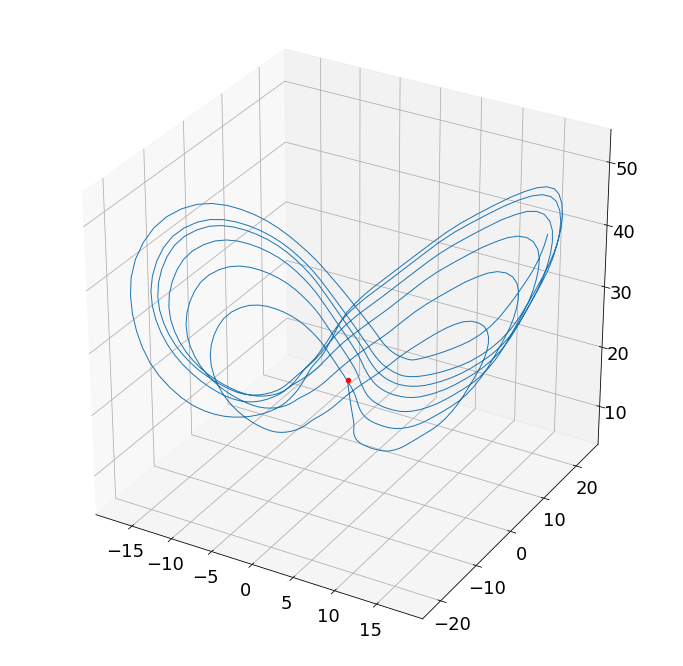

In [54]:
fig,ax = plt.subplots(1,1,subplot_kw={'projection': '3d'})
x, y, z = pred[:,:-1].T
ax.plot(x, y, z,linewidth=1)
ax.scatter(x[0],y[0],z[0],color='r')

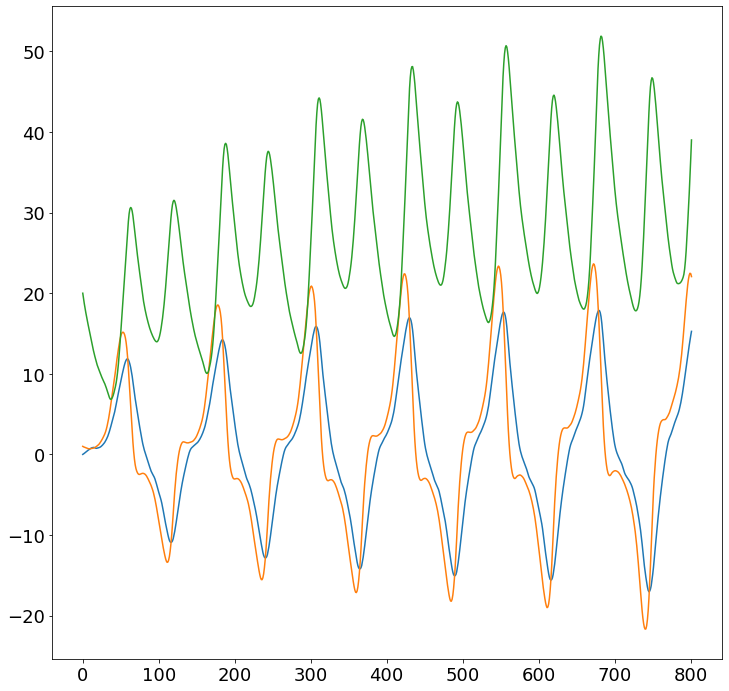

In [55]:
plt.plot(x)
plt.plot(y)
plt.plot(z)

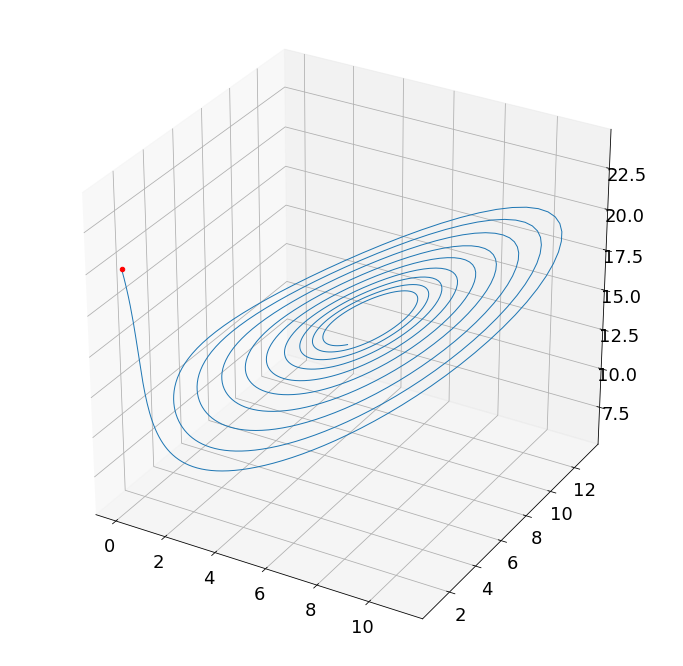

In [56]:
fig,ax = plt.subplots(1,1,subplot_kw={'projection': '3d'})
x, y, z = d[:,:-1].T
ax.plot(x, y, z,linewidth=1)
ax.scatter(x[0],y[0],z[0],color='r')

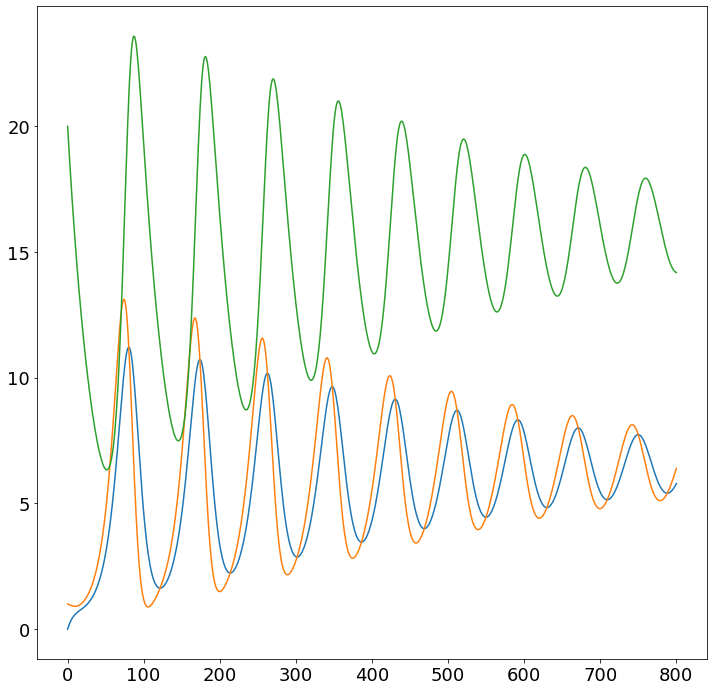

In [57]:
plt.plot(x)
plt.plot(y)
plt.plot(z)

In [58]:
rho = 35

x_t = integrate.odeint(lorenz_deriv, 
                       x0, 
                       t,
                       args=(sigma,beta,rho),
                       rtol=10**(-12), 
                       atol=10**(-12)*np.ones_like(x0))
x, y, z = x_t.T

r = x_t.shape[0]
d = np.hstack((x_t, (rho*np.ones(r)).reshape((r,1))))

In [59]:
len(t)

801

In [60]:
X0 = d[0]
pred = X0.reshape(1, 4)

for i in range(len(t)):
    X0 = model.predict(X0.reshape((1, 4)))
    pred = np.vstack([pred, X0]) 

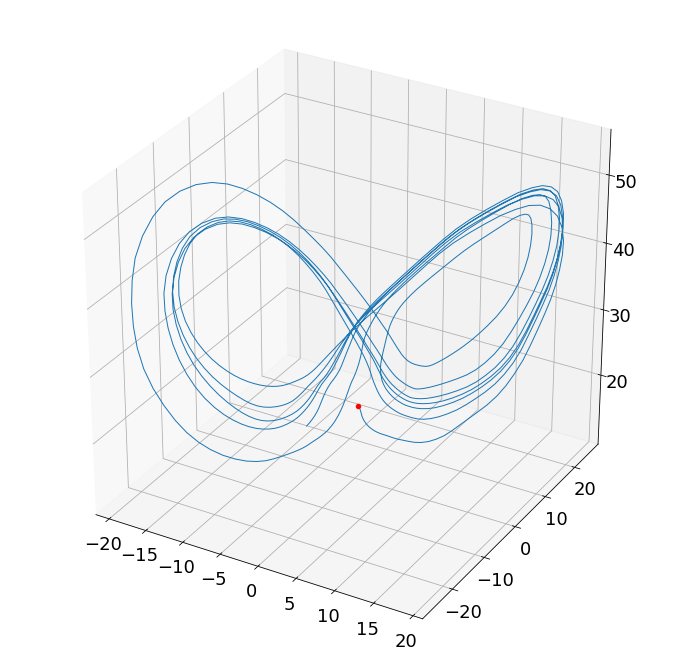

In [61]:
fig,ax = plt.subplots(1,1,subplot_kw={'projection': '3d'})
x, y, z = pred[:,:-1].T
ax.plot(x, y, z,linewidth=1)
ax.scatter(x[0],y[0],z[0],color='r')

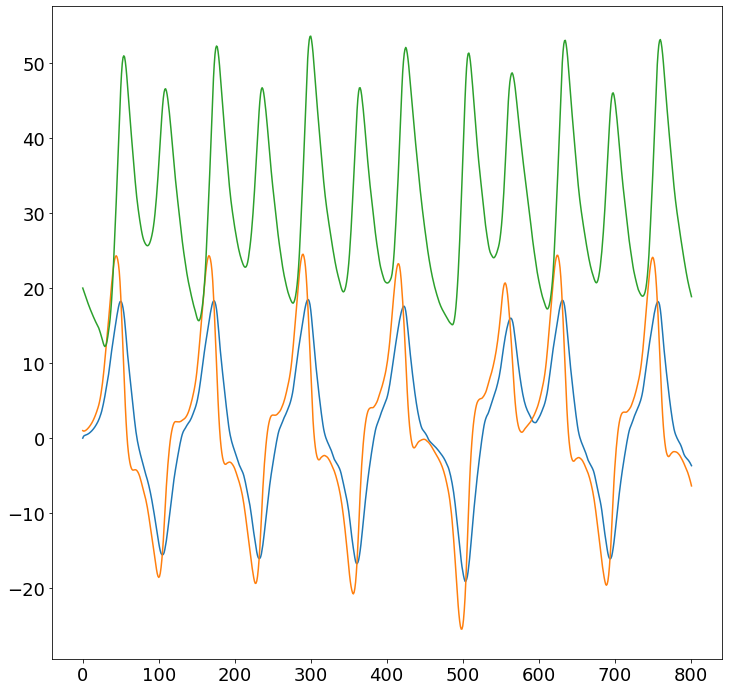

In [62]:
plt.plot(x)
plt.plot(y)
plt.plot(z)

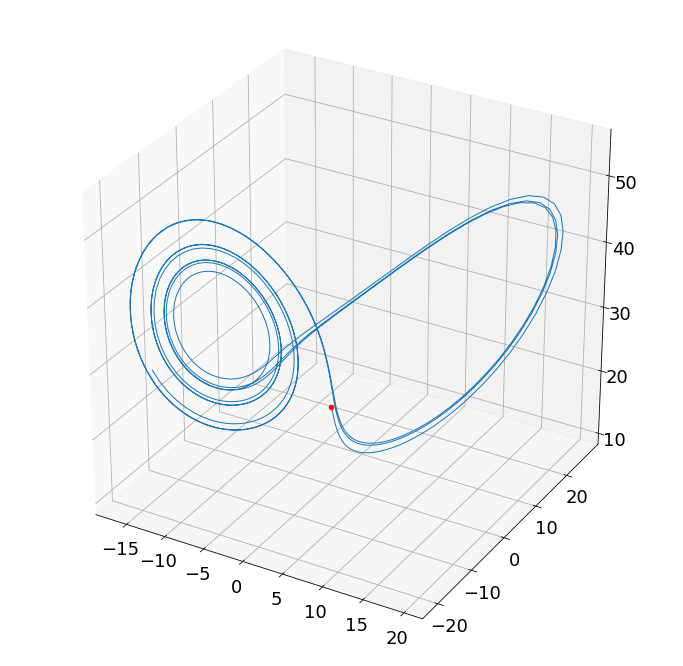

In [63]:
fig,ax = plt.subplots(1,1,subplot_kw={'projection': '3d'})
x, y, z = d[:,:-1].T
ax.plot(x, y, z,linewidth=1)
ax.scatter(x[0],y[0],z[0],color='r')

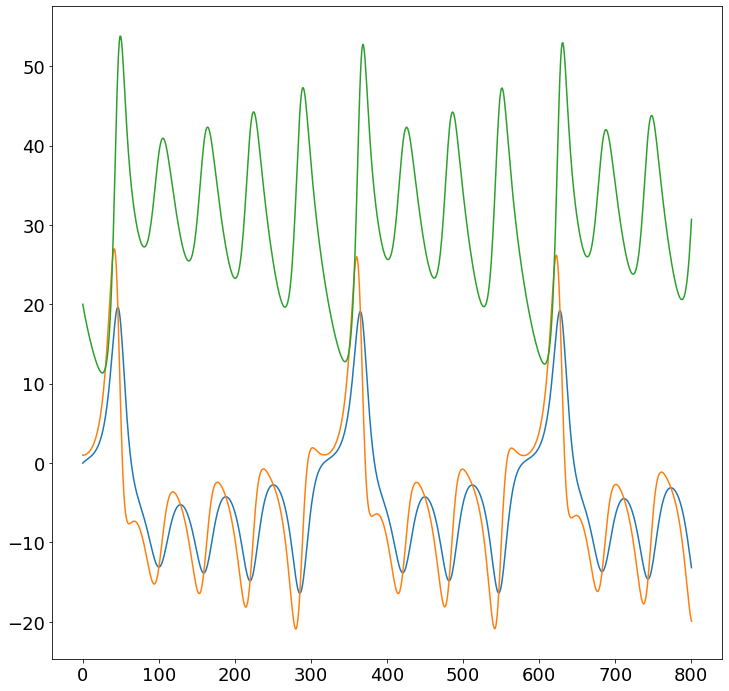

In [64]:
plt.plot(x)
plt.plot(y)
plt.plot(z)

### 2. See if you can train your NN to identify (for ρ = 28) when a transition from one lobe to another is imminent. Determine how far in advance you can make this prediction. (NOTE: you will have to label the transitions in a test set in order to do this task)

In [65]:
rho = 28

dt = 0.01
T = 128
t = np.arange(0,T+dt,dt)

x_t = integrate.odeint(lorenz_deriv, 
                       x0, 
                       t,
                       args=(sigma,beta,rho),
                       rtol=10**(-12), 
                       atol=10**(-12)*np.ones_like(x0))
x, y, z = x_t.T

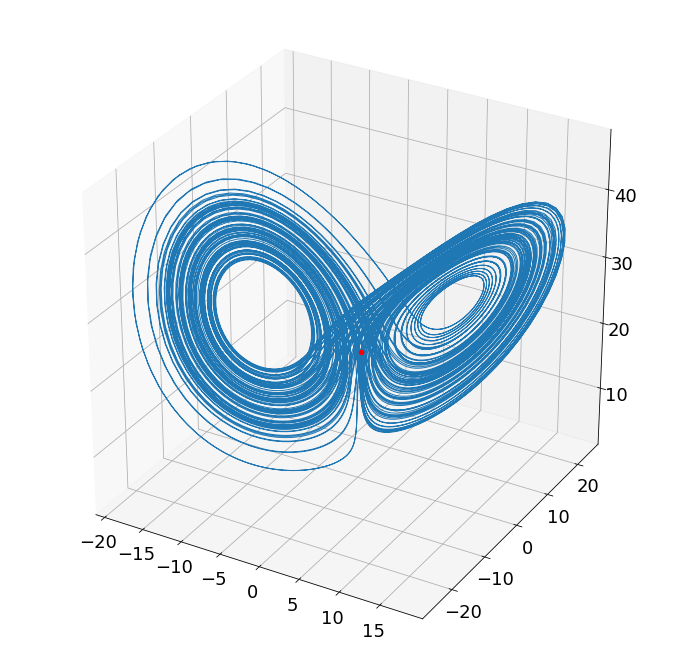

In [66]:
fig,ax = plt.subplots(1,1,subplot_kw={'projection': '3d'})
x, y, z = x_t.T
ax.plot(x, y, z,linewidth=1)
ax.scatter(x[0],y[0],z[0],color='r')

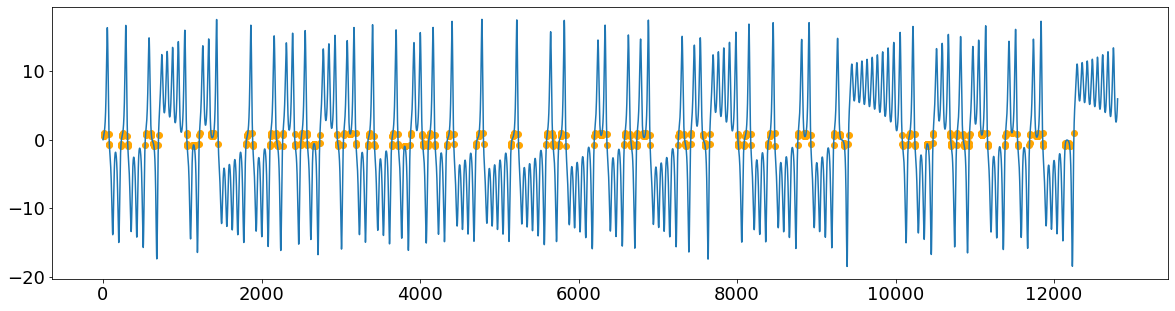

In [67]:
fig,ax = plt.subplots(figsize=(20,5))

z = np.where((x < 1) & (x > 0.5) | (x > -1) & (x < -0.5))

ax.plot(x)
# ax.scatter(np.arange(len(x)), x)
ax.scatter(np.arange(len(x))[z], x[z], color='orange')

In [68]:
g = np.zeros_like(x)

In [69]:
g[z] = 1

In [70]:
y = np.vstack([g,g,g]).T

In [71]:
X_train = x_t[:10000,:]
X_test  = x_t[10000:,:]
y_train = y[:10000,:]
y_test  = y[10000:,:]

In [72]:
model = Sequential()

model.add(Dense(100, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(X_train.shape[1]))

model.compile(optimizer=optimizers.Adam(learning_rate=0.001), loss='mse', validation_split=0.2)

In [73]:
%%capture
model.fit(X_train, y_train, epochs=200, batch_size=1000)
model.summary()

In [74]:
# model.save('models/LZt_model.h5')
model = load_model('models/LZt_model.h5')

In [75]:
X0 = model.predict(X_test)

In [76]:
x = X0.T[0]

In [77]:
z = np.where(x > 0.3)

In [78]:
y = X_test.T[0]

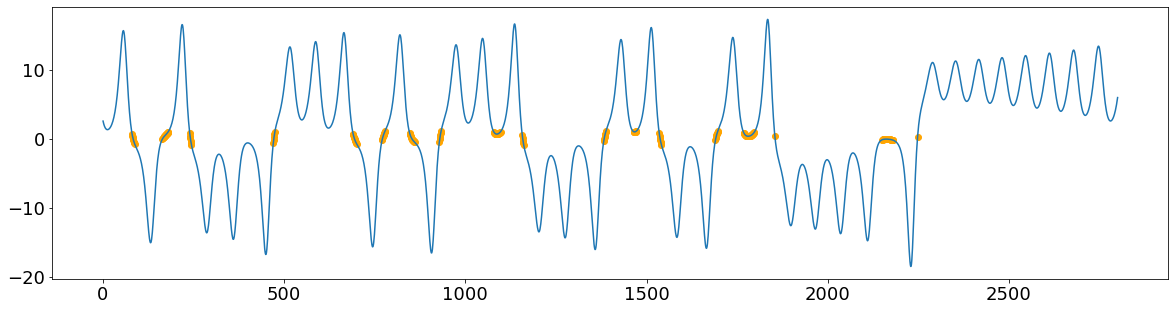

In [79]:
fig,ax = plt.subplots(figsize=(20,5))

ax.plot(y)
ax.scatter(np.arange(len(y))[z], y[z], color='orange')